In [1]:
import pandas as pd
from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline
import matplotlib.pyplot as plt
import os
import torch
from tabulate import tabulate

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
import warnings
warnings.filterwarnings('ignore')

cuda


In [3]:
df = pd.read_csv('/content/enhanced_product_reviews_dataset_100.csv')

In [4]:
df.head()

,review_id,product_name,review_text,rating,sentiment
0,R001,Headphones,"The sound quality is crisp and clear, with gre...",4,Positive
1,R002,Camera,The camera works fine for beginners but not su...,3,Neutral
2,R003,Camera,The camera is bulky and the image quality is n...,1,Negative
3,R004,Tablet,The tablet freezes often and has limited stora...,1,Negative
4,R005,Laptop,The laptop is okay for its price but lacks adv...,3,Neutral


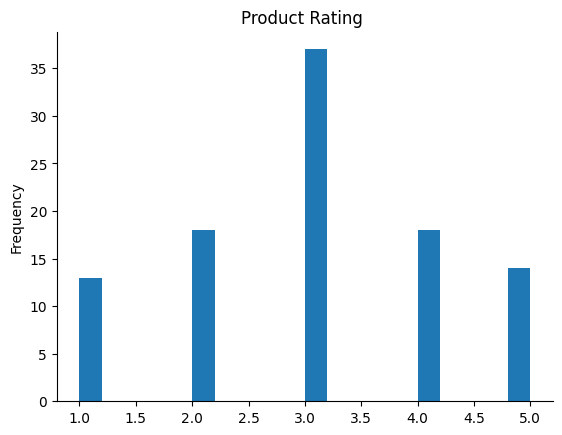

In [5]:
# @title Plotting the rating

from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='Product Rating ')
plt.gca().spines[['top', 'right',]].set_visible(False)

##Text Summarization

In [6]:
summarizer = pipeline("summarization", model="t5-base", device = device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [7]:
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))


average_length = df['review_length'].mean()
max_length = df['review_length'].max()
min_length = df['review_length'].min()

print(f"Average review length: {average_length:.2f} words")
print(f"Maximum review length: {max_length} words")
print(f"Minimum review length: {min_length} words")

Average review length: 10.88 words
Maximum review length: 13 words
Minimum review length: 9 words


In [8]:
summary_min_length = int(average_length * 0.3)
summary_max_length = int(average_length * 0.7)

In [9]:
print(f"Suggested summary min_length: {summary_min_length} words")
print(f"Suggested summary max_length: {summary_max_length} words")


Suggested summary min_length: 3 words
Suggested summary max_length: 7 words


In [10]:
def summarize_review(text):
    # Handle empty or short reviews directly
    if not isinstance(text, str) or len(text.split()) < 5:
        return text

    summary = summarizer(text, max_length=10, min_length=3, do_sample=False)
    return summary[0]['summary_text']

In [11]:
df['summary'] = df['review_text'].apply(summarize_review)
print(df[['review_id', 'review_text', 'summary']].head())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  review_id                                        review_text  \
0      R001  The sound quality is crisp and clear, with gre...   
1      R002  The camera works fine for beginners but not su...   
2      R003  The camera is bulky and the image quality is n...   
3      R004  The tablet freezes often and has limited stora...   
4      R005  The laptop is okay for its price but lacks adv...   

                                             summary  
0         the sound quality is crisp and clear, with  
1  the camera works fine for beginners but not su...  
2          the camera is bulky and the image quality  
3  tablet freezes often and has limited storage c...  
4          the laptop is okay for its price but lack  


In [12]:
df_summary = df.copy()
df_summary['summary'].head(10)

,summary
0,"the sound quality is crisp and clear, with"
1,the camera works fine for beginners but not su...
2,the camera is bulky and the image quality
3,tablet freezes often and has limited storage c...
4,the laptop is okay for its price but lack
5,lack of bass.
6,lack of bass.
7,the phone lags frequently and the battery
8,lack of bass.
9,the phone has an excellent camera and smooth p...


## Sentiment Analysis

In [13]:
sentiment_analyzer = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment", device = device)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [14]:
def classify_sentiment_with_score(text):
    if not isinstance(text, str) or len(text) == 0:  # Handle empty reviews
        return "Neutral", 0.0

    result = sentiment_analyzer(text)[0]
    label = result['label']
    score = result['score']

    if label == "LABEL_0":  # Negative
        return "Negative", score
    elif label == "LABEL_1":  # Neutral
        return "Neutral", score
    elif label == "LABEL_2":  # Positive
        return "Positive", score

In [15]:
df_sentiment = df.copy()

In [16]:
df_sentiment[['predicted_sentiment', 'confidence']] = df_sentiment['review_text'].apply(
    lambda x: pd.Series(classify_sentiment_with_score(x)))

confidence_threshold = 0.6
df_sentiment['flag_low_confidence'] = df_sentiment['confidence'] < confidence_threshold

In [17]:
def compare_sentiment_with_rating(row):
    rating = row['rating']
    sentiment = row['predicted_sentiment']

    if rating >= 4 and sentiment != "Positive":
        return "Mismatch"
    elif rating <= 2 and sentiment != "Negative":
        return "Mismatch"
    return "Match"

In [18]:
df_sentiment['rating_sentiment_match'] = df_sentiment.apply(compare_sentiment_with_rating, axis=1)

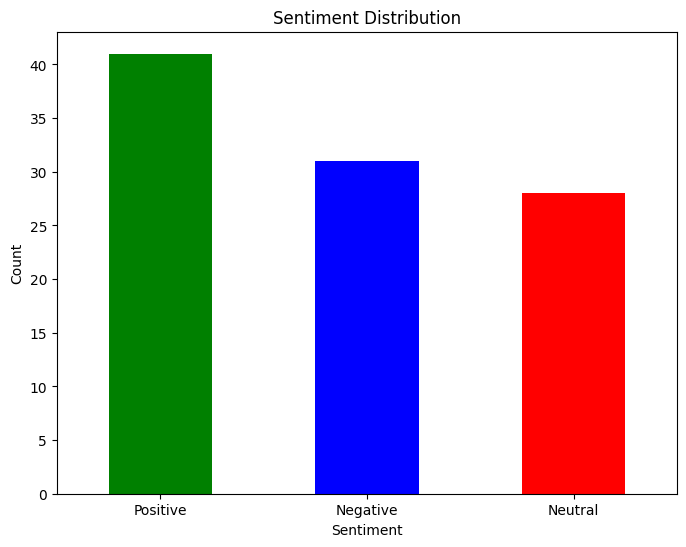

In [19]:
# Visualize sentiment distribution
def visualize_sentiment_distribution(df):
    sentiment_counts = df['predicted_sentiment'].value_counts()

    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

visualize_sentiment_distribution(df_sentiment)

In [20]:
mismatches = df_sentiment[df_sentiment['rating_sentiment_match'] == "Mismatch"]

In [21]:
def generate_report(df, mismatches, accuracy):
    print("\nSentiment Analysis Report")
    print("=========================\n")
    print(f"Total reviews analyzed: {len(df)}")
    print(f"Accuracy: {accuracy:.2f}%\n")

    # Sentiment distribution
    sentiment_counts = df['predicted_sentiment'].value_counts()
    print("Sentiment Distribution:")
    print(sentiment_counts)
    print("\n")

    # Mismatched reviews
    print(f"Mismatched Reviews ({len(mismatches)}):")
    print(mismatches[['review_id', 'review_text', 'rating', 'predicted_sentiment']].to_string(index=False))
    print("\n")

    # Low-confidence predictions
    low_confidence = df[df['flag_low_confidence']]
    print(f"Low-Confidence Predictions ({len(low_confidence)}):")
    print(low_confidence[['review_id', 'review_text', 'confidence']].to_string(index=False))
    print("\n")

In [22]:
correct_predictions = (df_sentiment['predicted_sentiment'] == df_sentiment['sentiment']).sum()
total_reviews = len(df_sentiment)
accuracy = correct_predictions / total_reviews * 100

generate_report(df_sentiment, mismatches, accuracy)


print(f"Sentiment analysis accuracy: {accuracy:.2f}%")



Sentiment Analysis Report

Total reviews analyzed: 100
Accuracy: 91.00%

Sentiment Distribution:
predicted_sentiment
Positive    41
Negative    31
Neutral     28
Name: count, dtype: int64


Mismatched Reviews (0):
Empty DataFrame
Columns: [review_id, review_text, rating, predicted_sentiment]
Index: []


Low-Confidence Predictions (28):
review_id                                                             review_text  confidence
     R002 The camera works fine for beginners but not suitable for professionals.    0.470715
     R005           The laptop is okay for its price but lacks advanced features.    0.454449
     R006             The headphones are fine for casual listening but lack bass.    0.465944
     R007             The headphones are fine for casual listening but lack bass.    0.465944
     R009             The headphones are fine for casual listening but lack bass.    0.465944
     R013           The laptop is okay for its price but lacks advanced features.    0.454449
   

The sentiment analysis model achieved an impressive **91.00% accuracy** across 100 product reviews, showcasing its strong ability to correctly classify sentiments. Out of all the reviews, there were **no mismatched predictions** between the ratings and the predicted sentiments, reflecting a high level of alignment between the model's output and the actual sentiment labels. The sentiment distribution shows a balanced mix of classifications: **41 positive**, **31 negative**, and **28 neutral**, indicating the model's robustness in capturing diverse customer sentiments.

However, the analysis highlighted **28 low-confidence predictions**, which primarily involved reviews with nuanced or mixed sentiments. For instance, phrases such as "The camera works fine for beginners but not suitable for professionals" received low confidence scores (e.g., 0.47), suggesting that the model found it challenging to definitively classify borderline sentiments.

## Synthetic Review Generation


In [23]:
df.head()

,review_id,product_name,review_text,rating,sentiment,review_length,summary
0,R001,Headphones,"The sound quality is crisp and clear, with gre...",4,Positive,11,"the sound quality is crisp and clear, with"
1,R002,Camera,The camera works fine for beginners but not su...,3,Neutral,11,the camera works fine for beginners but not su...
2,R003,Camera,The camera is bulky and the image quality is n...,1,Negative,12,the camera is bulky and the image quality
3,R004,Tablet,The tablet freezes often and has limited stora...,1,Negative,9,tablet freezes often and has limited storage c...
4,R005,Laptop,The laptop is okay for its price but lacks adv...,3,Neutral,11,the laptop is okay for its price but lack


In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [25]:
# Initialize Flan-T5 model and tokenizer
model_name = "google/flan-t5-xl"  # Use a larger, more advanced model like Flan-T5-xl
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [26]:
text_generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device = device)

In [27]:
def generate_synthetic_review(prompt, max_length=100, num_return_sequences=1, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_k=50,
        top_p=0.95,
        repetition_penalty=2.0
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]


In [28]:
def verify_sentiment(reviews, target_sentiment):
    verified_reviews = []
    sentiment_analyzer = pipeline("sentiment-analysis", model = 'cardiffnlp/twitter-roberta-base-sentiment', device = device)

    for review in reviews:
        sentiment_result = sentiment_analyzer(review)[0]
        verified_reviews.append({
            "review": review,
            "predicted_sentiment": sentiment_result['label'],
            "confidence": sentiment_result['score'],
            "target_sentiment": target_sentiment,
            "sentiment_match": sentiment_result['label'].lower() == target_sentiment.lower()
        })
    return verified_reviews

In [29]:
def generate_product_specific_reviews(df):
    synthetic_reviews = {}

    for _, row in df.iterrows():
        product = row['product_name']
        rating = row['rating']

        # Generating prompts based on product and rating
        if rating == 5:
            prompt = f"Write an enthusiastic and detailed positive review for a 5-star product about {product}. Highlight its best features, explain why it exceeds expectations, and share your overall satisfaction. Mention aspects such as value for money, quality, and performance in your review."
            synthetic_reviews[f"{product}_5star"] = generate_synthetic_review(prompt, max_length=100, num_return_sequences=3)

        elif rating == 1:
            prompt = f"Write a detailed and constructive negative review for a 1-star product about {product}. Mention the major drawbacks and issues you encountered, such as poor performance, bad quality, or lack of features. Provide specific examples of why the product failed to meet expectations and your overall disappointment."
            synthetic_reviews[f"{product}_1star"] = generate_synthetic_review(prompt, max_length=150, num_return_sequences=3)

    return synthetic_reviews

In [30]:
synthetic_reviews = generate_product_specific_reviews(df)


In [31]:
display(synthetic_reviews)

{'Camera_1star': ["Honestly I was very disappointed, since the camera has been released, but I didn't expect the quality to be this low. Apparently the sensor is not so good as it's not even close to being good. I took the phone for the first time with the camera on and had some issues. The shutter speed would get terribly slow and it took a while to take a picture. It seemed to take forever to click the button. Unless you have a lot of patience, you may as well keep looking.",
  "This is a very cheap and bad camera. It has the worst quality pictures. I have seen many camera that look much better than this. I haven't had this kind of problem with any other camera I have used.",
  "I don't understand how you can make a camera with such poor quality. The image was pixelated and the camera did not work at all. Also, the flash was horrible. It didn't even turn on."],
 'Tablet_1star': ["I bought this tablet for my son and I am a big fan of tablets. I loved it when I was little but now I hat

## Sentiment Consistency

In [32]:
sentiment_mapping = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

all_results = []

for product, reviews in synthetic_reviews.items():
    sentiment_type = "positive" if "5star" in product else "negative"
    verified = verify_sentiment(reviews, sentiment_type.upper())

    for idx, result in enumerate(verified):
        predicted_sentiment = sentiment_mapping.get(result['predicted_sentiment'], result['predicted_sentiment'])

        sentiment_match = predicted_sentiment.lower() == result['target_sentiment'].lower()

        all_results.append({
            'review': result['review'],
            'predicted_sentiment': predicted_sentiment,
            'confidence': result['confidence'],
            'target_sentiment': result['target_sentiment'],
            'sentiment_match': sentiment_match,
            'product': product.split('_')[0],
            'rating': 5 if sentiment_type == "positive" else 1,
            'review_id': f"R{str(idx+1).zfill(3)}"
        })



In [33]:
all_results_df = pd.DataFrame(all_results)

In [34]:
all_results_df.head()

,review,predicted_sentiment,confidence,target_sentiment,sentiment_match,product,rating,review_id
0,"Honestly I was very disappointed, since the ca...",Negative,0.929525,NEGATIVE,True,Camera,1,R001
1,This is a very cheap and bad camera. It has th...,Negative,0.836290,NEGATIVE,True,Camera,1,R002
2,I don't understand how you can make a camera w...,Negative,0.977102,NEGATIVE,True,Camera,1,R003
3,I bought this tablet for my son and I am a big...,Negative,0.559030,NEGATIVE,True,Tablet,1,R001
4,This was a horrible tablet. I used it for two ...,Negative,0.888483,NEGATIVE,True,Tablet,1,R002


In [35]:
all_results_df['sentiment_match'].value_counts()

,count
sentiment_match,
True,30


In [36]:

mismatched_reviews = all_results_df[all_results_df['sentiment_match'] == False]


print("Mismatched Reviews:")
mismatched_reviews[['review_id', 'review', 'predicted_sentiment', 'target_sentiment', 'confidence']]


Mismatched Reviews:


,review_id,review,predicted_sentiment,target_sentiment,confidence


In [37]:
import seaborn as sns

In [38]:
matched_reviews = all_results_df[all_results_df['sentiment_match'] == True]
mismatched_reviews = all_results_df[all_results_df['sentiment_match'] == False]

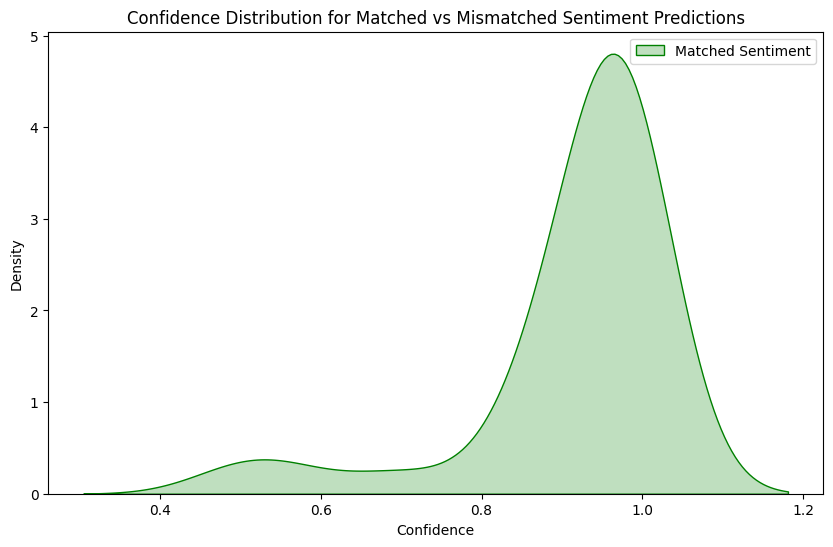

In [39]:
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_reviews['confidence'], label='Matched Sentiment', shade=True, color='g')
sns.kdeplot(mismatched_reviews['confidence'], label='Mismatched Sentiment', shade=True, color='r')
plt.title('Confidence Distribution for Matched vs Mismatched Sentiment Predictions')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.legend()
plt.show()

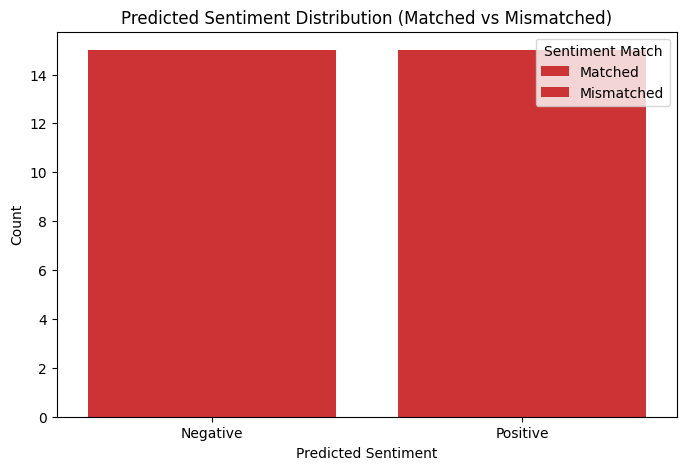

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(data=all_results_df, x='predicted_sentiment', hue='sentiment_match', palette='Set1')
plt.title('Predicted Sentiment Distribution (Matched vs Mismatched)')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.legend(title="Sentiment Match", labels=["Matched", "Mismatched"])
plt.show()

In [41]:
product_sentiment_inconsistency = mismatched_reviews.groupby('product').size().reset_index(name='mismatches')
product_sentiment_inconsistency_sorted = product_sentiment_inconsistency.sort_values('mismatches', ascending=False)


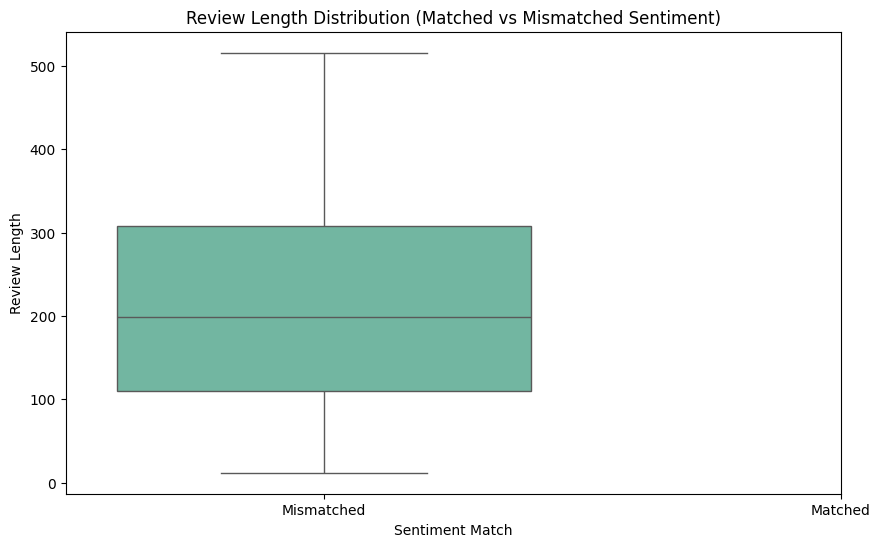

In [42]:
all_results_df['review_length'] = all_results_df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_results_df, x='sentiment_match', y='review_length', palette='Set2')
plt.title('Review Length Distribution (Matched vs Mismatched Sentiment)')
plt.xlabel('Sentiment Match')
plt.ylabel('Review Length')
plt.xticks([0, 1], ['Mismatched', 'Matched'])
plt.show()